In [211]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import logging

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units

import sys

sys.path.insert(0, '../')

from m_ff import models

logging.basicConfig(level=logging.INFO)
%matplotlib inline
%load_ext autoreload
%autoreload 2
from m_ff.calculators import CombinedSingleSpecies
from ase import Atoms
from ase.build import bulk, stack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [204]:
# Parameters
directory = 'data/Fe_db'
r_cut = 4.45
ntest = 100


## Configurations for testing purposes

In [206]:
# Get configurations and forces from file
elementslist = [26]
confs = np.load(directory + '/confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory + '/forces_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
tr_confs, tr_forces = confs[ind_tot[:ntr]], forces[ind_tot[:ntr]]
tst_confs, tst_forces = confs[ind_tot[ntr:]], forces[ind_tot[ntr:]]

## Load the mapped potential

In [208]:
m = models.CombinedSingleSpeciesModel.from_json(directory + "/combined_model_500_tr_80n3body.json")

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels
INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body kernels
INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body kernels


Loaded GP from file
Loaded GP from file


## Test the mapped potential on some configurations of the testing set

In [159]:
map_forces = np.zeros((ntest, 3))
map_error = np.zeros((ntest, 3))

calc = CombinedSingleSpecies(r_cut, m.grid_2b, m.grid_3b, rep_alpha = 0.0) # Setup the calculaor object

for i in np.arange(ntest):
    atoms = Atoms('Fe%i' %(1+len(tst_confs[i])), positions = np.vstack(([0, 0, 0], tst_confs[i][:,:3])), cell = 21.0*np.eye(3), pbc = [0, 0, 0] )
    atoms.set_calculator(calc)
    map_forces[i] = atoms.get_forces()[0]
    
map_error = map_forces - tst_forces

MAEF = np.mean(np.sqrt(np.sum(np.square(map_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(map_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:ini

MAEF on forces: 0.0817 +- 0.0503
Relative MAEF on forces: 0.0862 +- 0.0530


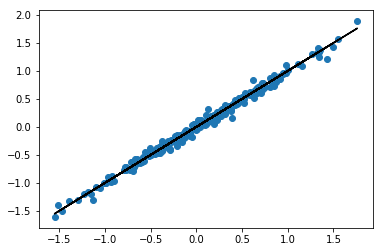

In [160]:
plt.scatter(tst_forces, map_forces)
plt.plot(tst_forces, tst_forces, 'k-')
plt.show()

## Run simple dynamics

Setup the ase calculator object, the rep_alpha parameter is used to define the strength of the Lennard Jones repulsion between atoms.
This is necessary because the database does not contains data regarding atoms which are very close and thereby cannot learn the atomic repulsion part of the potential. A parameter which is sensible for this iron system seems to be around 1.8-1.9.

In [215]:
calc = CombinedSingleSpecies(r_cut, m.grid_2b, m.grid_3b, rep_alpha = 1.9)
directory_2 = "data/Fe_various"
filename = directory_2 + '/gamma_database.xyz'
traj = read(filename, index=0)

In [216]:
# Setup atoms, remembering that the thickness of the cell in any direction must be above the r_cut (here set at 4.45 Angstrom).
atoms = traj
atoms = stack(atoms, atoms, axis=1)
atoms.set_calculator(calc)

In [214]:
# Simulation Variables Definition
gamma = 0.001
temp = 200 #K
dt = 1.0  # fs
steps = 10000
t = steps * dt * 10 ** (-3)  # time in ps

Stationary(atoms)
ZeroRotation(atoms)
dyn = VelocityVerlet(atoms, dt * units.fs)
MaxwellBoltzmannDistribution(atoms, 2.0*temp * units.kB)

In [200]:
# Define functions to print energy and save the trajectory.

def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def savexyz(a=atoms):
    this_traj = open(traj_filename, "a")
    write(this_traj, [atoms], format = 'extxyz')

In [201]:
traj_filename = "example.xyz"
this_traj = open(traj_filename, "w")
dyn.attach(savexyz, interval=50)
dyn.attach(printenergy, interval=10)

dyn.run(steps)

Energy per atom: Epot = -0.591eV  Ekin = 0.052eV (T=401K)  Etot = -0.539eV
Energy per atom: Epot = -0.590eV  Ekin = 0.051eV (T=398K)  Etot = -0.539eV
Energy per atom: Epot = -0.590eV  Ekin = 0.051eV (T=394K)  Etot = -0.539eV
Energy per atom: Epot = -0.589eV  Ekin = 0.050eV (T=387K)  Etot = -0.539eV
Energy per atom: Epot = -0.588eV  Ekin = 0.049eV (T=379K)  Etot = -0.539eV
Energy per atom: Epot = -0.587eV  Ekin = 0.048eV (T=369K)  Etot = -0.539eV
Energy per atom: Epot = -0.585eV  Ekin = 0.046eV (T=358K)  Etot = -0.539eV
Energy per atom: Epot = -0.584eV  Ekin = 0.045eV (T=346K)  Etot = -0.539eV
Energy per atom: Epot = -0.582eV  Ekin = 0.043eV (T=333K)  Etot = -0.539eV
Energy per atom: Epot = -0.580eV  Ekin = 0.041eV (T=318K)  Etot = -0.539eV
Energy per atom: Epot = -0.578eV  Ekin = 0.039eV (T=303K)  Etot = -0.539eV
Energy per atom: Epot = -0.576eV  Ekin = 0.037eV (T=287K)  Etot = -0.539eV
Energy per atom: Epot = -0.574eV  Ekin = 0.035eV (T=270K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=232K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=228K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=225K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=219K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=215K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=209K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=206K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=204K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=201K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=199K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=198K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=198K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=198K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=198K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=199K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=199K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=200K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=202K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.026eV (T=203K)  Etot = -0.539eV
Energy per atom: Epot = -0.565eV  Ekin = 0.027eV (T=205K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=207K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=210K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=215K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=210K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=210K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=211K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=216K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=217K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=219K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=221K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=224K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=225K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=227K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=228K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=229K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=230K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=230K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=232K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=233K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=234K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=235K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.030eV (T=235K)  Etot = -0.539eV
Energy per atom: Epot = -0.569eV  Ekin = 0.031eV (T=236K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=237K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=237K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=237K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=238K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=238K)  Etot = -0.539eV
Energy per atom: Epot = -0.570eV  Ekin = 0.031eV (T=238K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=220K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=219K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=218K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=217K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=216K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=215K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=213K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=213K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=213K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -0.566eV  Ekin = 0.027eV (T=212K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=213K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=214K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=215K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=215K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=216K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=217K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=217K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=218K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=218K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=218K)  Etot = -0.539eV
Energy per atom: Epot = -0.567eV  Ekin = 0.028eV (T=219K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -

Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=221K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=222K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=223K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=224K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=225K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=226K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=226K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=227K)  Etot = -0.539eV
Energy per atom: Epot = -0.568eV  Ekin = 0.029eV (T=227K)  Etot = -0.539eV
